In [5]:
# Imports
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from keras.optimizers import Adam
from google.colab import drive

ModuleNotFoundError: No module named 'google.colab'

In [3]:
# Plots Loss and accuracy of the train versus the validation data
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

# Load the data from local


In [4]:
# mount drive if working in google collab
drive.mount('/content/drive/')

'Nail'

In [5]:
# Load all the images from the "Nail" folder in your "raw_data" folder

categories = ['normal', 'beau_s line', 'black line', 'clubbing', 'mees_ line', 'onycholysis', 'terry_s nail', 'white spot']

X = []
y = []

# Load the images
local_path = os.path.join(os.path.expanduser('~'), 'code', 'ariannamng',
                              'predicting_nail_diseases',  'Nail')

for category in categories:
    path = f'/content/drive/My Drive/Colab Notebooks/predicting_nails/raw_data/Nail/{category}'

    for f in os.listdir(path):
            img = Image.open(os.path.join(path, f))
            foo = img.resize((256,256))
            X.append(np.array(foo))
            y.append(categories.index(category))


# Load the data for jupyter notebook

In [6]:
# Load all the images from the "Nail" folder in your "raw_data" folder

categories = ['normal', 'beau_s line', 'black line', 'clubbing', 'mees_ line', 'onycholysis', 'terry_s nail', 'white spot']

X = []
y = []

for category in categories:
    path = os.path.join(os.path.expanduser('~'), "code", "ariannamng",
                                   "predicting_nail_diseases", 'raw_data', 'Nail', category)

    for f in os.listdir(path):
            img = Image.open(os.path.join(path, f))
            foo = img.resize((256,256))
            X.append(np.array(foo))
            y.append(categories.index(category))


# Preprocessing

In [7]:
# Shuffel the data

c = list(zip(X, y))
np.random.shuffle(c)
X, y = zip(*c)
X = np.array(X)
y = np.array(y)

In [8]:
num_classes = 8
y = to_categorical(y, num_classes= num_classes)

In [9]:
# split data in test, val, train and preprocess data
ratio_train = 0.6
ratio_val = 0.2
len_train = int(X.shape[0]*ratio_train)
len_val = int(X.shape[0]*ratio_val)

X_train_processed = X[:len_train]/ 255. - 0.5
X_val_processed = X[len_train:(len_train+len_val)]/ 255. - 0.5
X_test_processed = X[(len_train+len_val):X.shape[0]]/ 255. - 0.5

y_train = y[:len_train]
y_val = y[len_train:(len_train+len_val)]
y_test = y[(len_train+len_val):X.shape[0]]

# TRANSFER LEARNING

In [10]:
# Compile the model as a binary classification model

#change learning rate adam, change dropout layer, try diffent neurons (now its 500) and change pacience of early stopping




def compile_model(model):
    '''return a compiled model for the baseline'''
    adam = Adam(learning_rate = 0.0001)

    model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
    return model

In [1]:
# Initialize and compile a model for a transfer learning

def build_model(base_model):
    '''instanciate and return the CNN architecture'''
    base_model.trainable = False
    flattening_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    drop_out = layers.Dropout(0.6)
    prediction_layer = layers.Dense(8, activation='softmax')

    model = Sequential([
      base_model,
      flattening_layer,
      dense_layer,
      drop_out,
      prediction_layer
      ])
    return compile_model(model)

# Data augmentation

In [12]:
# Add Data Augmentation if your model is overfitting
aug = ImageDataGenerator(
   rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
aug.fit(X_train_processed)

train_flow = aug.flow(X_train_processed, y_train, batch_size=16)
val_flow = aug.flow(X_val_processed, y_val, batch_size=16)

# VGG16 model

In [13]:
# Loads the VGG16 model
def load_VGG16_model():
    model = VGG16(weights="imagenet", include_top=False, input_shape=X_train_processed.shape[1:4])
    return model

In [ ]:
# Fit the VGG16 model on the train data
es = EarlyStopping(patience = 50 , restore_best_weights=True)
VGG16_model = build_model(load_VGG16_model())

history_VGG16 = VGG16_model.fit(
  train_flow,
  validation_data = val_flow,
  epochs = 200,
  batch_size = 32,
  verbose = 1,
  callbacks = [es]
)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.1193 - loss: 11.6993 - val_accuracy: 0.0938 - val_loss: 8.9665
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.1454 - loss: 8.6643 - val_accuracy: 0.1458 - val_loss: 6.7795
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.1279 - loss: 6.4553 - val_accuracy: 0.1354 - val_loss: 5.3035
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.0955 - loss: 5.1020 - val_accuracy: 0.1146 - val_loss: 4.3558
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.1032 - loss: 4.2313 - val_accuracy: 0.1354 - val_loss: 3.7549
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.1357 - loss: 3.6484 - val_accuracy: 0.1458 - val_loss: 3.3745
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.1128 - loss: 3.3123 - val_accuracy: 0.1354 - val_loss: 3.1370
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.1137 - loss: 3.0983 - val_accuracy: 0.1250 - 

In [ ]:
loss, accuracy = history_VGG16.evaluate(train_flow)
            print(f"Training Loss: {loss}, Training Accuracy: {accuracy}")

In [45]:
# Plot Loss and accuracy of the VGG16 model
plot_history(history_VGG16, title='VGG16', axs=None, exp_name="")

NameError: name 'history_VGG16' is not defined

In [ ]:
# Plot training & validation accuracy values
plt.plot(history_VGG16.history['accuracy'])
plt.plot(history_VGG16.history['val_accuracy'])
plt.title('VGG16 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_VGG16.history['loss'])
plt.plot(history_VGG16.history['val_loss'])
plt.title('VGG16 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the VGG16 model using the test data
VGG16_model.evaluate(X_test_processed, y_test, verbose=0)

[1.1535221338272095, 0.625]

# ResNet50

In [ ]:
# Loads the ResNet50 model
def load_ResNet50_model():
    model = ResNet50(weights="imagenet", include_top=False, input_shape=X_train_processed.shape[1:4])
    return model

In [ ]:
# Fit the ResNet50 model on the train data
es = EarlyStopping(patience = 10)
ResNet50_model = build_model(load_ResNet50_model())

history_ResNet50 = ResNet50_model.fit(
  X_train_processed,
  y_train,
  validation_split = 0.2,
  epochs = 500,
  batch_size = 32,
  verbose = 0,
  callbacks = [es]
)

94765736/94765736 [==============================] - 3s 0us/step


(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

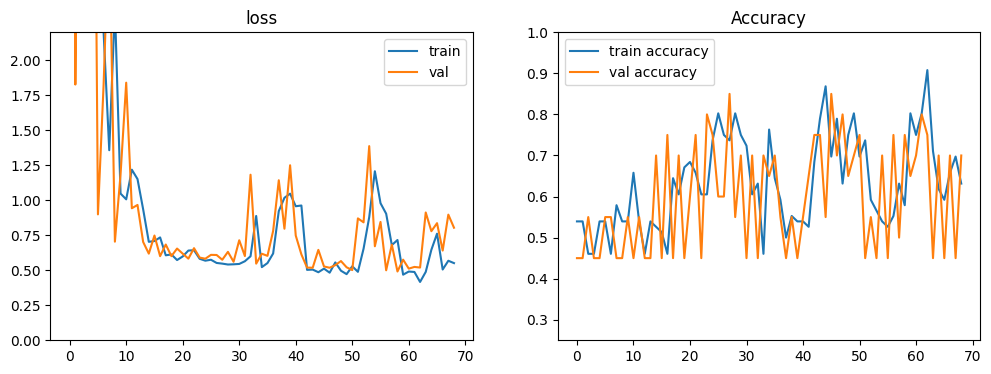

In [ ]:
# Plot Loss and accuracy of the ResNet50 model
plot_history(history_ResNet50, title='ResNet50', axs=None, exp_name="")

In [ ]:
# Evaluate the ResNet50 model using the test data
ResNet50_model.evaluate(X_test_processed, y_test, verbose=0)

[0.7244213223457336, 0.5833333134651184]

# EfficientNetB0

In [ ]:
# Loads the EfficientNetB0 model
def load_EfficientNetB0_model():
    model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=X_train_processed.shape[1:4])
    return model

In [ ]:
# Fit the EfficientNetB0 model on the train data
es = EarlyStopping(patience = 10)
EfficientNetB0_model = build_model(load_EfficientNetB0_model())

history_EfficientNetB0 = EfficientNetB0_model.fit(
  X_train_processed,
  y_train,
  validation_split = 0.2,
  epochs = 500,
  batch_size = 32,
  verbose = 1,
  callbacks = [es]
)

In [ ]:
# Plot Loss and accuracy of the EfficientNetB0 model
plot_history(history_EfficientNetB0, title='EfficientNetB0', axs=None, exp_name="")

In [ ]:
# Evaluate the EfficientNetB0 model using the test data
EfficientNetB0_model.evaluate(X_test_processed, y_test, verbose=0)